In [1]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
import matplotlib.pyplot as plt

## Utility Functions

In [2]:
def key_invariant_chromagram(y, sr):
    """Compute the key-invariant chromagram of an audio signal."""
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=24)
    chroma_sum = chroma.sum(axis=1)
    key = max(range(12), key=lambda i: np.corrcoef(np.roll(chroma_sum, -i), [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])[0, 1])
    return np.roll(chroma, -key, axis=0)


def find_anchor_frame(beats, tempo, sr):
    """Determine the first beat frame that best matches the expected beat interval given a tempo and sample rate."""
    expected_interval = int(librosa.time_to_frames(60.0 / tempo, sr=sr))
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i]) for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]


def create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration_in_frames):
    """Create a grid of measures based on the tempo, time signature, and beats of the song. """
    if not anchor_frame:
        anchor_frame = beats[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)
        
    # Group beats into measures
    measure_grid = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measure_grid.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature

    # Insert 0 if not already in the list
    if measure_grid[0] != 0:
        measure_grid.insert(0, 0)
    
    # Append the duration if not already in the list
    if measure_grid[-1] != duration_in_frames:
        measure_grid.append(duration_in_frames)
    
    return np.array(beat_grid), np.array(measure_grid)


def generate_and_align_labels(df, n_frames, measure_grid_frames):
    """Create a binary label sequence for 'chorus' in a song and align it to a measure grid."""
    binary_label_sequence = np.zeros(n_frames, dtype=int)
    binary_label_sequence[df[df['label'] == 'chorus']['start_frame'].values] = 1
    return np.array([
        int(np.mean(binary_label_sequence[s:e]) >= 0.25)
        for s, e in zip(measure_grid_frames[:-1], measure_grid_frames[1:])
    ])


def segment_data_measures(data, measure_grid_frames):
    """Divide song data into segments based on measure grid frames."""
    return [data[s:e] for s, e in zip(measure_grid_frames[:-1], measure_grid_frames[1:])]


def positional_encoding(position, d_model):
    """Generate a positional encoding for a given position and model dimension."""
    angle_rads = (
        np.arange(position)[:, np.newaxis] /
        np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    )
    return np.concatenate([np.sin(angle_rads[:, 0::2]), np.cos(angle_rads[:, 1::2])], axis=-1)


def apply_hybrid_positional_encoding(segments):
    """Apply positional encoding at the measure and frame levels to a list of segments."""
    n_features = segments[0].shape[1]
    measure_level_encodings = positional_encoding(len(segments), n_features)
    return [
        seg + positional_encoding(len(seg), n_features) + measure_level_encodings[i] 
        for i, seg in enumerate(segments)
    ]

## Data Extraction

In [5]:
# Load data
df = pd.read_csv('../data/dataframes/clean_labeled.csv')

# Prepare directories
segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"
os.makedirs(segment_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Process DataFrame by SongID
for song_id, group in tqdm(df.groupby('SongID'), desc='Processing'):
    audio_path = group['FilePath'].values[0]
    y, sr = librosa.load(audio_path, sr=None)

    # Feature extraction and normalization
    features = {
        'rms': librosa.feature.rms(y=y),
        'C': f,
    }
    features['rms'] = (features['rms'] - np.min(features['rms'])) / (np.max(features['rms']) - np.min(features['rms']))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(features['C'], ref=np.max))

    # Tempo and beat tracking
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    bpm = group['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
    time_signature = int(group['sp_time_signature'].fillna(4).replace(0, 4).values[0])
    beat_interval_in_frames = librosa.time_to_frames(60/bpm, sr=sr)

    # Further feature processing
    combined_features = np.concatenate([
        features['rms'],
        librosa.feature.tempogram_ratio(tg=librosa.feature.tempogram(onset_envelope=onset_env, sr=sr), sr=sr),
        key_invariant_chromagram(y, sr),
        librosa.feature.tonnetz(y=None, sr=sr, chroma=make_key_invariant_chromagram(y, sr))
    ], axis=0).T

    # Measure grid creation and label alignment
    anchor_frame = find_anchor_frame(beats, bpm, sr)
    beat_grid, measure_grid = create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, len(combined_features))
    aligned_labels = generate_and_align_labels(group, len(combined_features), measure_grid)

    # Segment and encode features
    encoded_features = apply_hybrid_positional_encoding(segment_data_measures(combined_features, measure_grid))
    
    # Save results
    with open(f"{segment_dir}/{song_id}_encoded.pkl", "wb") as f:
        pickle.dump(encoded_features, f)
    with open(f"{labels_dir}/{song_id}_labels.pkl", "wb") as f:
        pickle.dump(aligned_labels, f)

Processing: 100%|██████████| 332/332 [34:33<00:00,  6.25s/it]


## Load pickled data

In [3]:
def load_pickles_from_directory(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data.append(data)
    return all_data
    
# Directories containing the pickled files
segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"

# Load all segments and labels
all_segments = load_pickles_from_directory(segment_dir)
all_labels = load_pickles_from_directory(labels_dir)

## Padding and reshaping

In [4]:
def find_max_frames_and_measures(all_segments):
    """
    Find the maximum number of frames per measure and the maximum number of measures across all songs.
    
    Parameters:
    - all_segments: list, segmented data for all songs.
    
    Returns:
    - int, maximum number of frames per measure.
    - int, maximum number of measures.
    """
    max_frames_per_measure = max(max(len(m[0]) for m in s) for s in all_segments)
    max_measures = max(len(s) for s in all_segments)
    return max_frames_per_measure, max_measures


def pad_measures(all_segments, max_frames_per_measure):
    """
    Pad all measures within each song to have the same number of frames with zero padding.
    
    Parameters:
    - all_segments: list, segmented data for all songs.
    - max_frames_per_measure: int, maximum number of frames per measure.
    
    Returns:
    - list, padded measures.
    """
    return [
        [np.pad(m[0], ((0, max_frames_per_measure - m[0].shape[0]), (0, 0)), 'constant', constant_values=0) for m in song]
        for song in all_segments
    ]


def pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features=32):
    """
    Pad all songs to have the same number of measures with zero padding.
    
    Parameters:
    - padded_measures: list, padded measures.
    - max_measures: int, maximum number of measures.
    - max_frames_per_measure: int, maximum number of frames per measure.
    - n_features: int, number of features.
    
    Returns:
    - list, padded songs.
    """
    padding_measure = np.zeros((max_frames_per_measure, n_features))
    return [
        song + [padding_measure] * (max_measures - len(song)) for song in padded_measures
    ]


def pad_labels(all_labels, max_measures):
    """
    Pad all label sequences to have the same number of measures with -1 padding.
    
    Parameters:
    - all_labels: list, label sequences for all songs.
    - max_measures: int, maximum number of measures.
    
    Returns:
    - list, padded labels.
    """
    return [np.pad(labels, (0, max_measures - len(labels)), 'constant', constant_values=-1)
            for labels in all_labels]


# Find the maximum frames per measure and maximum measures across all songs
max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)

# First, pad measures within each song to have the same number of frames
padded_measures = pad_measures(all_segments, max_frames_per_measure)

# Then, pad all songs to have the same number of measures
padded_songs = pad_songs(padded_measures, max_measures, max_frames_per_measure)

# Pad labels to match the structure of padded_segments
padded_labels = pad_labels(all_labels, max_measures)

## Generate train, validation, and test sets

In [5]:
def split_data(padded_songs, padded_labels):
    """
    Split the data into train, validation, and test sets.
    """
    # Define the number of songs
    num_songs = len(padded_songs)

    # Create indices for the songs
    indices = np.arange(num_songs)

    # Split indices into training and temporary (validation + test) sets
    train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)

    # Further split the temporary set into validation and test sets
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

    # Generate the actual train, validation, and test sets using the indices
    X_train = [padded_songs[i] for i in train_indices]
    y_train = [padded_labels[i] for i in train_indices]

    X_val = [padded_songs[i] for i in val_indices]
    y_val = [padded_labels[i] for i in val_indices]

    X_test = [padded_songs[i] for i in test_indices]
    y_test = [padded_labels[i] for i in test_indices]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def data_generator(X, y):
    """Generator function to yield batches of data."""
    for features, labels in zip(X, y):
        # Convert features to a NumPy array with shape: (num_measures, num_frames, 32)
        features_array = np.array(features)
        
        # Reshape labels to have an additional dimension: (num_measures, 1)
        labels_reshaped = np.expand_dims(labels, axis=-1)
        
        yield features_array, labels_reshaped

def create_dataset(X, y, batch_size):
    """Create a TensorFlow dataset from the generator function."""
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(X, y),
        output_signature=(
            tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
        )
    ).batch(batch_size)
    
    return dataset

# Split the data into train, validation, and test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(padded_songs, padded_labels)

# Define the batch size as the number of songs per batch
batch_size = 32

# Create the train, validation, and test datasets
train_dataset = create_dataset(X_train, y_train, batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size)

## Define CRNN model and custom loss/accuracy and metrics

In [109]:
def custom_binary_crossentropy(y_true, y_pred):
    """
    Custom binary cross-entropy loss to handle -1 labels, which are used for padding and should be ignored during loss calculation.
    
    Args:
    y_true (tf.Tensor): True labels.
    y_pred (tf.Tensor): Predicted labels.
    
    Returns:
    loss (tf.Tensor): Loss value.
    """
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    """Custom accuracy metric to handle -1 labels, which are used for padding and should be ignored during accuracy calculation."""
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)
    return accuracy


class TransformerEncoderLayer(layers.Layer):
    """Implements a Transformer encoder layer."""
    def __init__(self, num_heads, d_model, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def create_transformer_padding_mask(lstm_output):
    """Create a padding mask for the Transformer model."""
    mask = tf.reduce_sum(tf.abs(lstm_output), axis=-1)
    mask = tf.cast(tf.equal(mask, 0), tf.float32)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    mask = mask[:, tf.newaxis, tf.newaxis, :]
    mask = mask * tf.ones((1, 1, tf.shape(mask)[-1], tf.shape(mask)[-1]))
    return mask


def create_crnn_model(max_frames_per_measure, max_measures, feature_per_frame):
    """
    Args:
    max_frames_per_measure (int): Maximum number of frames per measure.
    max_measures (int): Maximum number of measures.
    feature_per_frame (int): Number of features per frame.
    """
    frame_input = layers.Input(shape=(max_frames_per_measure, feature_per_frame))
    conv1 = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(frame_input)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    conv2 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    conv3 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    frame_features = layers.Flatten()(pool3)
    frame_feature_model = Model(inputs=frame_input, outputs=frame_features)

    measure_input = layers.Input(shape=(max_measures, max_frames_per_measure, feature_per_frame))
    time_distributed = layers.TimeDistributed(frame_feature_model)(measure_input)
    masking_layer = layers.Masking(mask_value=0.0)(time_distributed)
    lstm_out = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(masking_layer)
    output = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(lstm_out)
    model = Model(inputs=measure_input, outputs=output)
    model.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=[custom_accuracy])
    return model

In [110]:
feature_per_frame = 32
#max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)
model = create_crnn_model(max_frames_per_measure, max_measures, feature_per_frame)
model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 204, 320, 32)]    0         
                                                                 
 time_distributed_38 (TimeDi  (None, 204, 10240)       307840    
 stributed)                                                      
                                                                 
 masking_19 (Masking)        (None, 204, 10240)        0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 512)         21497856  
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 204, 1)           513       
 stributed)                                                      
                                                          

## Train the model

In [112]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the directories for checkpoints and models
checkpoint_dir = os.path.join('..', 'checkpoints', 'CRNN')
model_dir = os.path.join('..', 'models', 'CRNN')

# Ensure the checkpoint and model directories exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Define the checkpoint path for the best model
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

callbacks = [
    ModelCheckpoint(
        filepath=best_model_filepath,
        save_weights_only=False,
        monitor='val_custom_accuracy',  # Use 'val_custom_accuracy' for validation custom accuracy
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',  
        patience=3,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.1,
        patience=2,
        verbose=1,
        min_delta=0.0001,
        min_lr=0.00001
    )
]

# Train the model with the simplified callbacks list
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
      8/Unknown - 53s 7s/step - loss: 0.6244 - custom_accuracy: 0.5859 - accuracy: 0.3069
Epoch 1: val_custom_accuracy improved from -inf to 0.59171, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 57s 7s/step - loss: 0.6244 - custom_accuracy: 0.5859 - accuracy: 0.3069 - val_loss: 0.5895 - val_custom_accuracy: 0.5917 - val_accuracy: 0.3018 - lr: 0.0010
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 0.5885 - custom_accuracy: 0.6111 - accuracy: 0.3202
Epoch 2: val_custom_accuracy improved from 0.59171 to 0.70113, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 56s 7s/step - loss: 0.5885 - custom_accuracy: 0.6111 - accuracy: 0.3202 - val_loss: 0.5615 - val_custom_accuracy: 0.7011 - val_accuracy: 0.3574 - lr: 0.0010
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 0.5630 - custom_accuracy: 0.6965 - accuracy: 0.3642
Epoch 3: val_custom_accuracy did not improve from 0.70113


## Test the model

In [115]:
# Define the path to the best model
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

# Load the best model
best_model = load_model(best_model_filepath, custom_objects=custom_objects)

# Evaluate the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 5s 1s/step - loss: 0.5263 - custom_accuracy: 0.7115 - accuracy: 0.3675
Test Loss: 0.5263184905052185
Test Accuracy: 0.7114821672439575


## Evaluate the model

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'])  
plt.plot(history.history['val_custom_accuracy'])  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Visualizing model predictions 

In [18]:
import os
import pickle

def load_pickles_from_directory(directory, data_type):
    all_data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            # Extract the songid from the filename
            # The filename is expected to be in the format "{song_id}_{data_type}.pkl"
            song_id = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data[song_id] = data  # Use song_id as key
    return all_data

# Directories containing the pickled files
segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"

# Load all segments and labels
# Specify the data type when calling the function
all_segments = load_pickles_from_directory(segment_dir, "encoded")
all_labels = load_pickles_from_directory(labels_dir, "labels")

In [19]:
def find_max_frames_and_measures(all_segments):
    max_frames_per_measure = max(max(len(m[0]) for m in s) for s in all_segments.values())
    max_measures = max(len(s) for s in all_segments.values())
    return max_frames_per_measure, max_measures

def pad_measures(all_segments, max_frames_per_measure):
    padded_segments = {}
    for song_id, song in all_segments.items():
        padded_measures = [
            np.pad(m[0], ((0, max_frames_per_measure - m[0].shape[0]), (0, 0)), 'constant', constant_values=0) for m in song
        ]
        padded_segments[song_id] = padded_measures
    return padded_segments

def pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features=32):
    padding_measure = np.zeros((max_frames_per_measure, n_features))
    padded_songs = {}
    for song_id, song in padded_measures.items():
        padded_song = song + [padding_measure] * (max_measures - len(song))
        padded_songs[song_id] = padded_song
    return padded_songs

def pad_labels(all_labels, max_measures):
    padded_labels = {}
    for song_id, labels in all_labels.items():
        padded_label = np.pad(labels, (0, max_measures - len(labels)), 'constant', constant_values=-1)
        padded_labels[song_id] = padded_label
    return padded_labels

def split_data(padded_songs, padded_labels):
    # Create lists of song IDs
    song_ids = list(padded_songs.keys())

    # Split song IDs into training and temporary (validation + test) sets
    train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)

    # Further split the temporary set into validation and test sets
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

    # Generate the actual train, validation, and test sets using the song IDs
    X_train = {song_id: padded_songs[song_id] for song_id in train_ids}
    y_train = {song_id: padded_labels[song_id] for song_id in train_ids}

    X_val = {song_id: padded_songs[song_id] for song_id in val_ids}
    y_val = {song_id: padded_labels[song_id] for song_id in val_ids}

    X_test = {song_id: padded_songs[song_id] for song_id in test_ids}
    y_test = {song_id: padded_labels[song_id] for song_id in test_ids}
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def data_generator(X, y):
    """Generator function to yield batches of data."""
    for song_id in X:
        # Convert features to a NumPy array with shape: (num_measures, num_frames, 32)
        features_array = np.array(X[song_id])
        
        # Reshape labels to have an additional dimension: (num_measures, 1)
        labels_reshaped = np.expand_dims(y[song_id], axis=-1)
        
        yield features_array, labels_reshaped

def create_dataset(X, y, batch_size):
    """Create a TensorFlow dataset from the generator function."""
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(X, y),
        output_signature=(
            tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
        )
    ).batch(batch_size)
    
    return dataset

# Find the maximum frames per measure and maximum measures across all songs
max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)

# First, pad measures within each song to have the same number of frames
padded_measures = pad_measures(all_segments, max_frames_per_measure)

# Then, pad all songs to have the same number of measures
padded_songs = pad_songs(padded_measures, max_measures, max_frames_per_measure)

# Pad labels to match the structure of padded_segments
padded_labels = pad_labels(all_labels, max_measures)

# Split the data into train, validation, and test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(padded_songs, padded_labels)

# Define the batch size as the number of songs per batch
batch_size = 32

# Create the train, validation, and test datasets
train_dataset = create_dataset(X_train, y_train, batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size)

In [12]:
from tensorflow.keras.models import load_model

def custom_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)
    return accuracy

# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

# Load the saved model with the custom objects
model = load_model(best_model_filepath, custom_objects=custom_objects)

In [29]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def find_anchor_frame(beats, tempo, sr):
    expected_interval = int(librosa.time_to_frames(60.0 / tempo, sr=sr))
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i]) for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]


def create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration_in_frames):
    if not anchor_frame:
        anchor_frame = beats[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)

    # Group beats into measures
    measure_grid = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measure_grid.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature

    # Insert 0 if not already in the list
    if measure_grid[0] != 0:
        measure_grid.insert(0, 0)

    # Append the duration if not already in the list
    if measure_grid[-1] != duration_in_frames:
        measure_grid.append(duration_in_frames)

    return np.array(beat_grid), np.array(measure_grid)


# Get a list of song IDs from the keys of the dictionary
song_ids = list(X_test.keys())

# Select a random song ID
random_song_id = random.choice(song_ids)

df = pd.read_csv('../data/dataframes/clean_labeled.csv')
data = df.loc[df['SongID']==int(random_song_id)].copy()

# Load the audio file corresponding to the random song ID
audio_files_dir = '../data/audio_files/processed'
audio_path = os.path.join(audio_files_dir, f'{random_song_id}.mp3')
y, sr = librosa.load(audio_path, sr=None)  
C = librosa.cqt(y=y, sr=sr)
S = librosa.amplitude_to_db(np.abs(C), ref=np.max)
onset_env = librosa.onset.onset_strength(sr=sr, S=S)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])
beat_interval_in_frames = librosa.time_to_frames(60/bpm, sr=sr)
anchor_frame = find_anchor_frame(beats, bpm, sr)
_, measure_grid = create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, len(S.T))
measure_grid_times = librosa.frames_to_time(measure_grid, sr=sr)

1/1 [==============================] - 1s 607ms/step


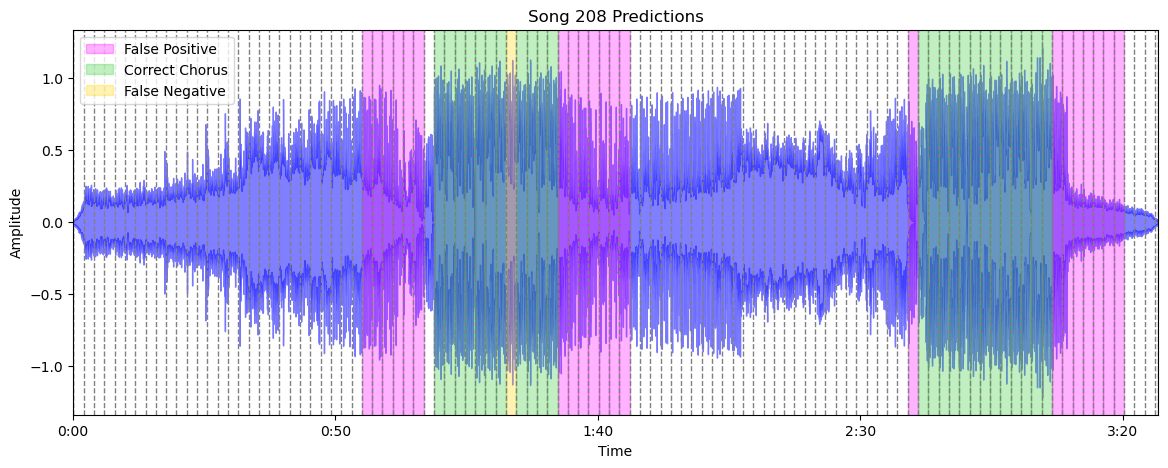

In [55]:
import matplotlib.patches as mpatches

def apply_measure_grid(ax, measure_grid_times):
    for time in measure_grid_times:
        ax.axvline(x=time, color='grey', linestyle='--', linewidth=1, alpha=0.6)
        
def highlight_predictions(ax, unpadded_predictions, true_labels, measure_grid_times, sr):
    """Overlay the predicted sections based on the measure grid, predictions array, and true labels."""
    # Define colors for each type of prediction
    colors = {'Correct Chorus': 'limegreen', 'False Positive': 'fuchsia', 'False Negative': 'gold'}
    # Initialize a dictionary to keep track of whether a legend item has been added
    legend_added = {'Correct Chorus': False, 'False Positive': False, 'False Negative': False}

    for measure_index in range(len(unpadded_predictions)):
        start_time = measure_grid_times[measure_index]
        end_time = measure_grid_times[measure_index + 1]
        label = None
        if unpadded_predictions[measure_index] and true_labels[measure_index]:
            color = colors['Correct Chorus']
            label = 'Correct Chorus' if not legend_added['Correct Chorus'] else ""
            legend_added['Correct Chorus'] = True
        elif unpadded_predictions[measure_index] and not true_labels[measure_index]:
            color = colors['False Positive']
            label = 'False Positive' if not legend_added['False Positive'] else ""
            legend_added['False Positive'] = True
        elif not unpadded_predictions[measure_index] and true_labels[measure_index]:
            color = colors['False Negative']
            label = 'False Negative' if not legend_added['False Negative'] else ""
            legend_added['False Negative'] = True
        else:
            continue

        # Highlight the measure
        ax.axvspan(start_time, end_time, color=color, alpha=0.3, label=label)
        
        
# Get the corresponding test data and label
test_song = np.array(X_test[random_song_id], dtype=np.float32)
test_label = np.array(y_test[random_song_id], dtype=np.float32)
# Generate predictions for the selected song
# Reshape the song data to match the expected input shape of the model
test_song_reshaped = np.expand_dims(test_song, axis=0)
predictions = model.predict(test_song_reshaped)
predictions = predictions.flatten() > 0.5  # Apply threshold to get binary results

num_measures = len(measure_grid)-1
unpadded_predictions = predictions[:num_measures]

# Convert chorus start and end frames to a binary array of true labels
true_labels = np.zeros(num_measures, dtype=bool)
choruses = data.loc[data['label'] == 'chorus']
for index, chorus in choruses.iterrows():
    start_time = librosa.frames_to_time(chorus['start_frame'], sr=sr)
    end_time = librosa.frames_to_time(chorus['end_frame'], sr=sr)
    # Find the measures that the chorus spans
    for measure_index, (measure_start, measure_end) in enumerate(zip(measure_grid_times[:-1], measure_grid_times[1:])):
        if start_time < measure_end and end_time > measure_start:
            true_labels[measure_index] = True
            
    
# Generate the plot
fig, ax = plt.subplots(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, color='b', alpha=0.5)
ax.set_xlim([0, len(y) / sr])
apply_measure_grid(ax, measure_grid_times)

highlight_predictions(ax, unpadded_predictions, true_labels, measure_grid_times, sr)

ax.set_ylabel('Amplitude')
ax.set_title(f'Song {random_song_id} Predictions')

# Create the legend
handles, labels = ax.get_legend_handles_labels()
# Filter out any extra handles
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), loc='best')

plt.show()

In [57]:
len(X_test)

50

In [26]:
def find_anchor_frame(beats, tempo, sr):
    expected_interval = int(librosa.time_to_frames(60.0 / tempo, sr=sr))
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i]) for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]


def create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration_in_frames):
    if not anchor_frame:
        anchor_frame = beats[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)

    # Group beats into measures
    measure_grid = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measure_grid.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature

    # Insert 0 if not already in the list
    if measure_grid[0] != 0:
        measure_grid.insert(0, 0)

    # Append the duration if not already in the list
    if measure_grid[-1] != duration_in_frames:
        measure_grid.append(duration_in_frames)

    return np.array(beat_grid), np.array(measure_grid)

In [27]:
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
data = df.loc[df['SongID']==int(random_song_id)].copy()
# Feature extraction and normalization
features = {
    'rms': librosa.feature.rms(y=y),
    'C': np.abs(librosa.cqt(y=y, sr=sr)),
}
features['rms'] = (features['rms'] - np.min(features['rms'])) / (np.max(features['rms']) - np.min(features['rms']))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(features['C'], ref=np.max))

# Tempo and beat tracking
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
# Make sure to define or replace `group['sp_tempo']` and `group['sp_time_signature']` with valid values
bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])
beat_interval_in_frames = librosa.time_to_frames(60/bpm, sr=sr)

# Measure grid creation and label alignment
# Make sure the functions `find_anchor_frame` and `create_beat_grid` are defined
anchor_frame = find_anchor_frame(beats, bpm, sr)
beat_grid, measure_grid = create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, len(features))

IndexError: list index out of range

In [22]:
# Plot waveform and overlay measure grid
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title(f'Waveform and Measure Grid for Song ID {random_song_id}')

# Apply the measure grid to the plot
apply_measure_grid(ax, measure_grid)

# Show the plot
plt.tight_layout()
plt.show()

{'241': [array([[ 6.92145986e-05,  2.60884416e+00,  2.92268192e-01, ...,
           1.97352763e+00, -2.36994377e-02,  1.97323853e+00],
         [ 8.41551742e-01,  2.15023210e+00,  8.26183201e-01, ...,
           1.98139615e+00, -2.24180966e-02,  1.97557777e+00],
         [ 9.09386860e-01,  1.19486272e+00,  1.19588977e+00, ...,
           1.97504201e+00, -2.14273850e-02,  1.97878014e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
  array([[ 1.37581989e+00,  2.17266398e+00,  8.42039381e-01, ...,
           2.01772764e+00,  6.51298018e-04,  1.99983223e+00],
         [ 2.22837627e+00,  1.71391946e+00,  1.37590178e+00, ...,
           2.01